In [1]:
#|default_exp conv

## Convolutions

In [2]:
#|export 
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [3]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [4]:
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, weuse a convolution requires nothing more than multiplication, and addition

In [6]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

In [7]:
mpl.rcParams['figure.dpi'] = 30

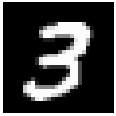

In [8]:
im3 = x_imgs[7]
show_image(im3);

In [9]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

We're going to call this our kerneral (because that's what fancy computer vision researchers call these).

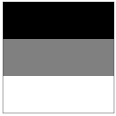

In [10]:
show_image(top_edge, noframe=False);

In [11]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [12]:
(im3[3:6, 14:17] * top_edge).sum()

tensor(2.9727)

In [13]:
(im3[7:10, 14:17] * top_edge).sum()

tensor(-2.9570)

In [14]:
def apply_kernel(row, col, kernel): return (im3[row-1:row+2,col-1:col+2] * kernel).sum()

In [15]:
apply_kernel(4,15,top_edge)

tensor(2.9727)

In [16]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

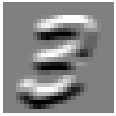

In [17]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

In [18]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

<Axes: >

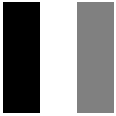

In [19]:
show_image(left_edge)

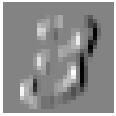

In [20]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

In [21]:
import torch.nn.functional as F
import torch

In [22]:
inp = im3[None, None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([9, 676])

In [23]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [24]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

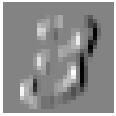

In [25]:
out = out_unf.view(26,26)
show_image(out);

In [26]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

11.4 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

73 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%timeit -n 100 F.conv2d(inp, left_edge[None,None])

The slowest run took 94.54 times longer than the fastest. This could mean that an intermediate result is being cached.
502 µs ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

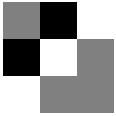

In [30]:
show_image(diag1_edge);

In [31]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

<Axes: >

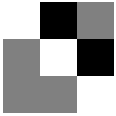

In [32]:
show_image(diag2_edge)

In [33]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [34]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [35]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

<Axes: >

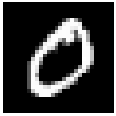

In [36]:
img0 = xb[1,0]
show_image(img0)

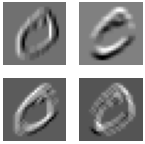

In [37]:
show_images([batch_features[1,i] for i in range(4)])

### Creating the CNN

In [38]:
n,m = x_train.shape
c = y_train.max() + 1
nh = 50

In [39]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10))

In [40]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [41]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [42]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [43]:
simple_cnn = nn.Sequential(
    conv(1 ,4),         #14x14
    conv(4 ,8),         #7x7
    conv(8 ,16),        #4x4
    conv(16,16),        #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten(), 
)

In [44]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [45]:
x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds,valid_ds = Dataset(x_imgs, y_train),Dataset(xv_imgs, y_valid)

In [46]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(o.to(device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [47]:
from torch import optim

bs = 256
lr = 0.4
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [48]:
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

/home/chung/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


0 0.2796485413074493 0.9163999995231629
1 0.15439452426433564 0.9543000005722045
2 0.23587504506111145 0.9289000003814697
3 0.13732430274486543 0.960600000667572
4 0.11614935925006867 0.9672000005722046


In [49]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,acc = fit(5, simple_cnn, F.cross_entropy, opt, train_dl, valid_dl)

0 0.0830899897813797 0.9753999995231628
1 0.08396211814880371 0.9752999995231628
2 0.08279012169837952 0.9763999995231628
3 0.08211243286132812 0.9762999995231628
4 0.08248150508403779 0.9764999995231628


In [50]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [53]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [54]:
conv1.bias.shape

torch.Size([4])

In [55]:
from torchvision.io import read_image

In [57]:
im = read_image('images/grizzly.jpg')
im.shape

torch.Size([3, 1000, 846])

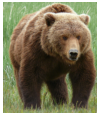

In [58]:
show_image(im.permute(1,2,0));

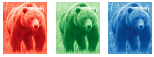

In [60]:
_,axs = plt.subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')): show_image(255-bear, ax=ax, cmap=color)